In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
# from dance_evaluation import *
import matplotlib.pyplot as plt
# from calculate_score import *
from collections import defaultdict

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

def save_to_pickle(filepath, data):
    # filepath = os.path.join(savepath, filename)
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

In [2]:
def compute_dts(
    ref_bpm,
    estimated_bpm,
    tau=0.06,
    mode="one"
):
    """
    Continuous Dance-Tempo Score (DTS), with support for
    either single estimates (mode="one") or multiple
    candidates per frame (mode="many").

    Parameters
    ----------
    ref_bpm : array-like, shape (n,)
        Ground-truth musical tempo in BPM.
    estimated_bpm : 
        If mode="one": array-like, shape (n,)
        If mode="many": iterable of length-n, each element
                        is an iterable of candidate BPMs.
    tau : float, optional
        Tolerance in octaves (0.06 ≈ 4 %).
    mode : {"one", "many"}
        “one”: treat `estimated_bpm` as a flat sequence.
        “many”: pick, for each i, the candidate closest to ref_bpm[i].

    Returns
    -------
    dts : ndarray, shape (n,)
        Scores in [0, 1] (1 = perfect, 0 = miss ≥ τ octaves away).
    e : ndarray, shape (n,)
        Raw octave errors log₂(estimate/ref).
    d : ndarray, shape (n,)
        Wrapped distance to {-1, 0, +1} before clipping.
    """
    ref_bpm = np.asarray(ref_bpm, dtype=float)

    # select a single estimate per index if needed
    if mode == "many":
        # estimated_bpm is e.g. [(b1, b2,...), (c1, c2,...), ...]
        chosen = np.array([
            min(cands, key=lambda b: abs(b - ref_bpm[i]))
            for i, cands in enumerate(estimated_bpm)
        ], dtype=float)
    elif mode == "one":
        chosen = np.asarray(estimated_bpm, dtype=float)
    else:
        raise ValueError(f"Unknown mode: {mode!r}. Use 'one' or 'many'.")

    # now compute the DTS exactly as before
    e = np.log2(chosen / ref_bpm)
    # distance from nearest of -1, 0, +1
    d = np.abs(e[:, None] - np.array([-1.0, 0.0, 1.0])).min(axis=1)
    # clip by tolerance and convert to score
    d_clip = np.minimum(d, tau)
    dts    = 1.0 - d_clip / tau

    accuracy = (dts > 0.0).mean() * 100
    
    # hits ----------------------------------------------------------
    hit_mask = dts > 0.0          # inside ±tau band
    hit_idx = np.nonzero(hit_mask)[0]
    ref_hit_bpm = ref_bpm[hit_idx]
    
    return dts, e, d, accuracy


In [3]:
from collections import defaultdict

# helper to compute accuracy and fill a dictionary
def collect_accuracies(folder, metric_tag):
    acc = {}
    for fname in os.listdir(folder):
        tag = fname.split("_zero_uni")[0]
        data = load_pickle(f"{folder}/{fname}")
        ref  = data["music_tempo"].to_numpy()
        _, _, _, accuracy = compute_dts(ref, data["bpm_median"].to_numpy(),
                                        tau=0.10, mode="one")
        if tag in friendly:
            acc[friendly[tag] ] = round(accuracy, 2)
    return acc


friendly = {
    "both_hand_y":  "both_hand_y",
    "both_foot_y":  "both_foot_y",
    "adaptv_Bhandfoot_y": "adaptv_Bhandfoot_y"
}

a, b = 25, 140
root = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result"
root_adap = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result_adaptive"


tdir_names = os.listdir(root)
tempo_ranges = [tuple(map(int, name.split("_")[1:])) for name in tdir_names]
# tempo_ranges = sorted(tempo_ranges, key=lambda x: x[0]) # sort by lower bound
# tempo_labels = [f"{a}-{b}" for a, b in tempo_ranges]

tempo_ranges = [
    (30, 120),
    (30, 140),
    (30, 180),
    (30, 240),
    (60, 120),
    (60, 140),
    (80, 140),
    (80, 200),
]

tempo_labels = ['30-120',    '30-140',    '30-180',    '30-240',    
                '60-120',    '60-140',    '80-140',    '80-200',]
acc_hand = []
acc_foot = []
acc_Bhandfoot_adap = []


for a, b in tempo_ranges:
    pth_pos = f"{root}/tempo_{a}_{b}/pos"
    pth_pos_adap = f"{root_adap}/tempo_{a}_{b}/pos"
    
    accuracy_dict_pos = collect_accuracies(pth_pos, "pos")
    accuracy_dict_pos_adap = collect_accuracies(pth_pos_adap, "pos")
    

    acc_hand.append(accuracy_dict_pos.get("both_hand_y", None))
    acc_foot.append(accuracy_dict_pos.get("both_foot_y", None))
    acc_Bhandfoot_adap.append(accuracy_dict_pos_adap.get("adaptv_Bhandfoot_y", None))



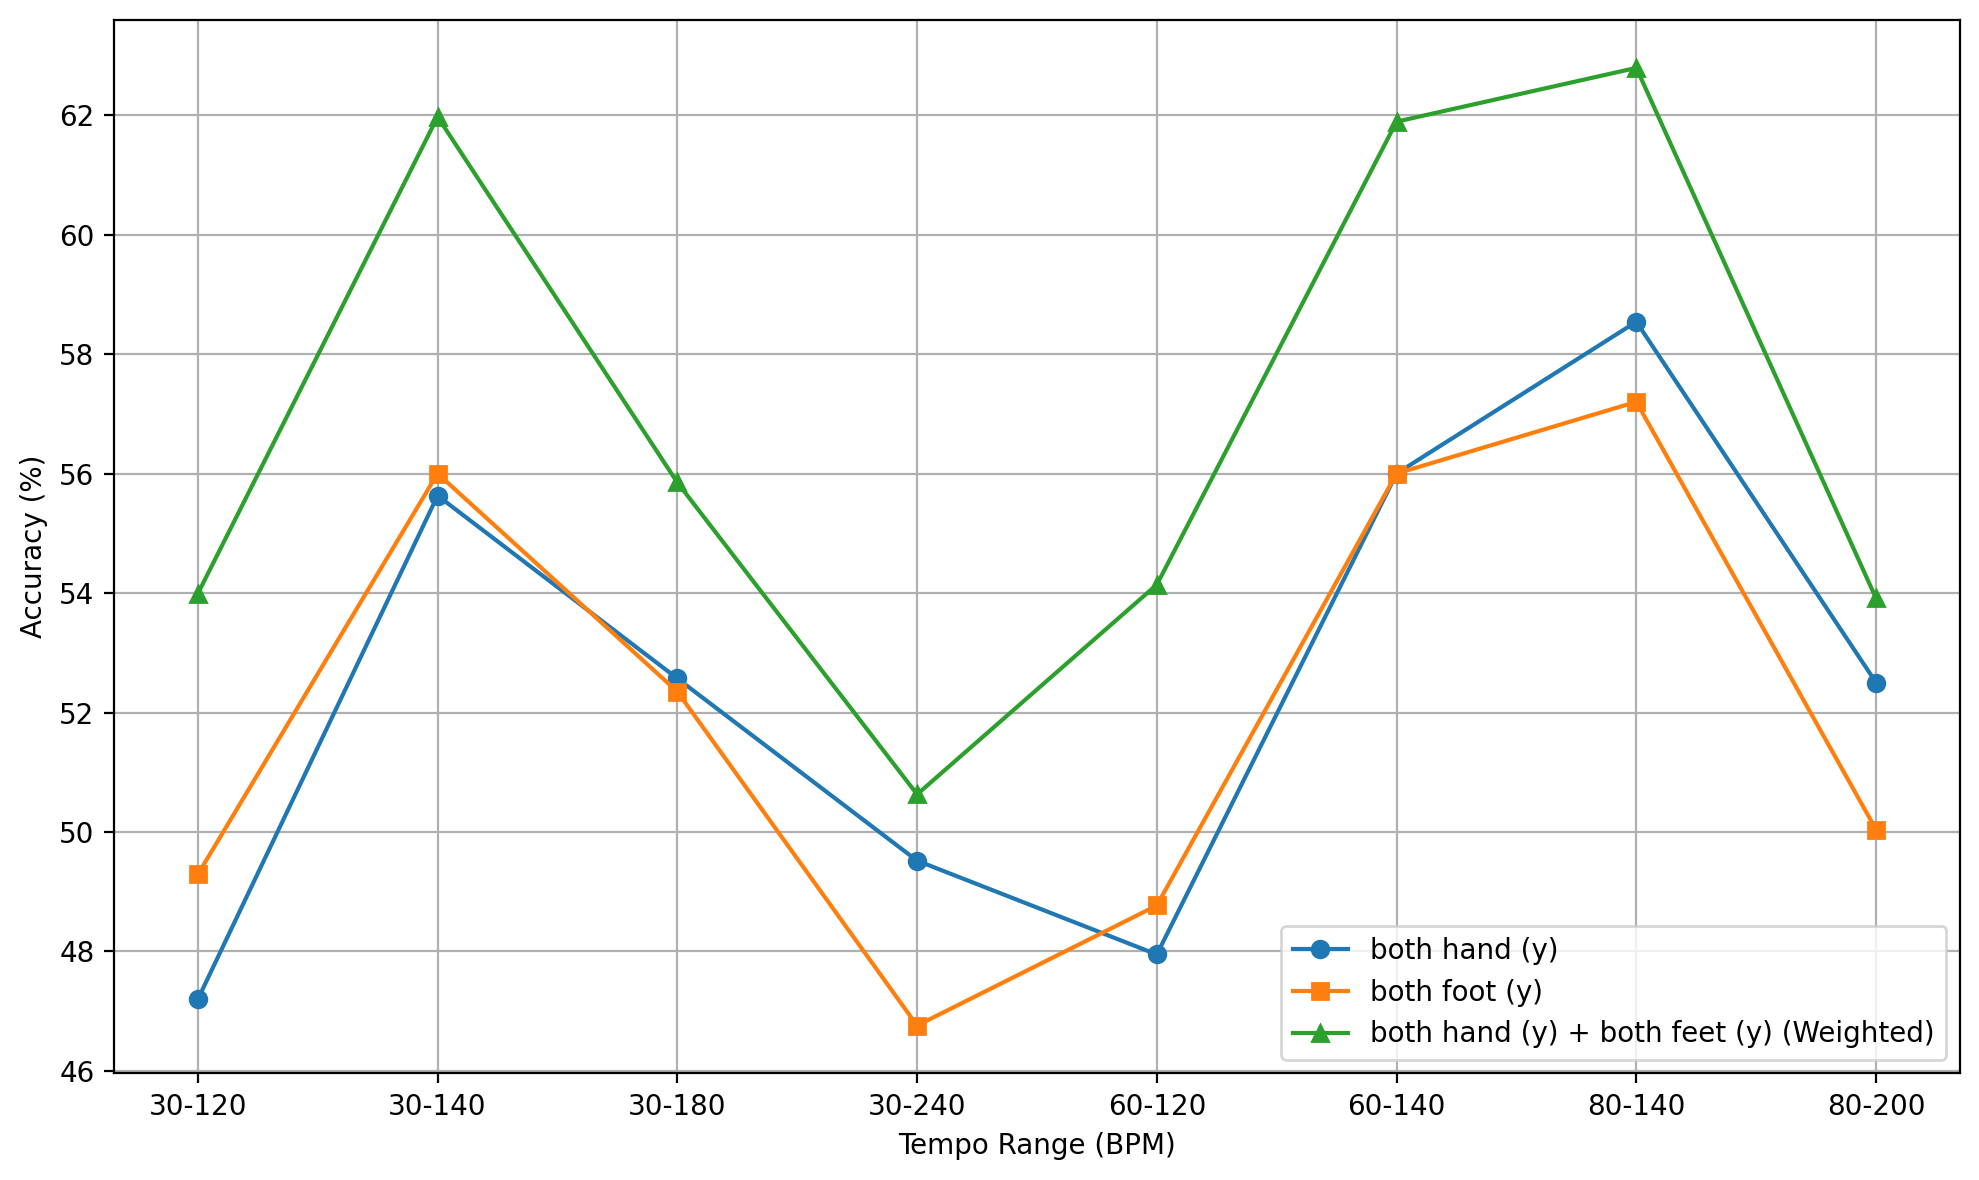

In [12]:
# plot
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(tempo_labels, acc_hand, marker='o', label= "both hand (y)")
plt.plot(tempo_labels, acc_foot, marker='s', label= "both foot (y)")
plt.plot(tempo_labels, acc_Bhandfoot_adap, marker='^', label= "both hand (y) + both feet (y) (Weighted)")

# plt.xticks(rotation=45)
plt.xlabel("Tempo Range (BPM)")
plt.ylabel("Accuracy (%)")
# plt.title("Accuracy vs. Tempo Range")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Window Size vs. Accuracy

In [3]:
def estimate_tempo_one(a, b, mode, metric, w_sec, h_sec, tau=0.10):

    segment_keys = ["both_hand_y", "both_foot_y",]
    
    json_data = {}
    
    bpm_dict = ["bpm_median"]   # "bpm_avg",  "bpm_mode", 
    oPath = f"./saved_result_cases/window_cases/"
    for bpm_mode in bpm_dict:

        # json_data[bpm_mode] = {}
        
        for idx, f_name in enumerate(segment_keys):
            f_path = oPath + f"{metric}/{f_name}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            df_ax = pd.read_pickle(f_path)
            
            ref = df_ax["music_tempo"].to_numpy()
            _, _, _, dts_acc = compute_dts(ref, np.asarray(df_ax[bpm_mode]), tau= tau, mode = "one")
                                 
            json_data[f_name] = dts_acc #{"dts_acc": dts_acc}

    return json_data


In [4]:
pair_keys = ["both_hand_y", "both_foot_y",]

a = 60; b= 140
mode = "zero_uni"
metric = "pos"
w_sec_list = np.arange(1,10).tolist()

wcase_data = {
    key: {
        "w_sec": [],
        "h_sec": [],
        "dts_acc": [],

    }
    for key in pair_keys
}

for w_sec in w_sec_list:
    # print(w_sec)
    for fraction in [0.25, 0.5, 0.75, 1]:
        h_sec = w_sec * fraction
        t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)
        
        for ky, itm in t_data.items():
            wcase_data[ky]["w_sec"].append(w_sec)
            wcase_data[ky]["h_sec"].append(fraction)
            wcase_data[ky]["dts_acc"].append(itm)

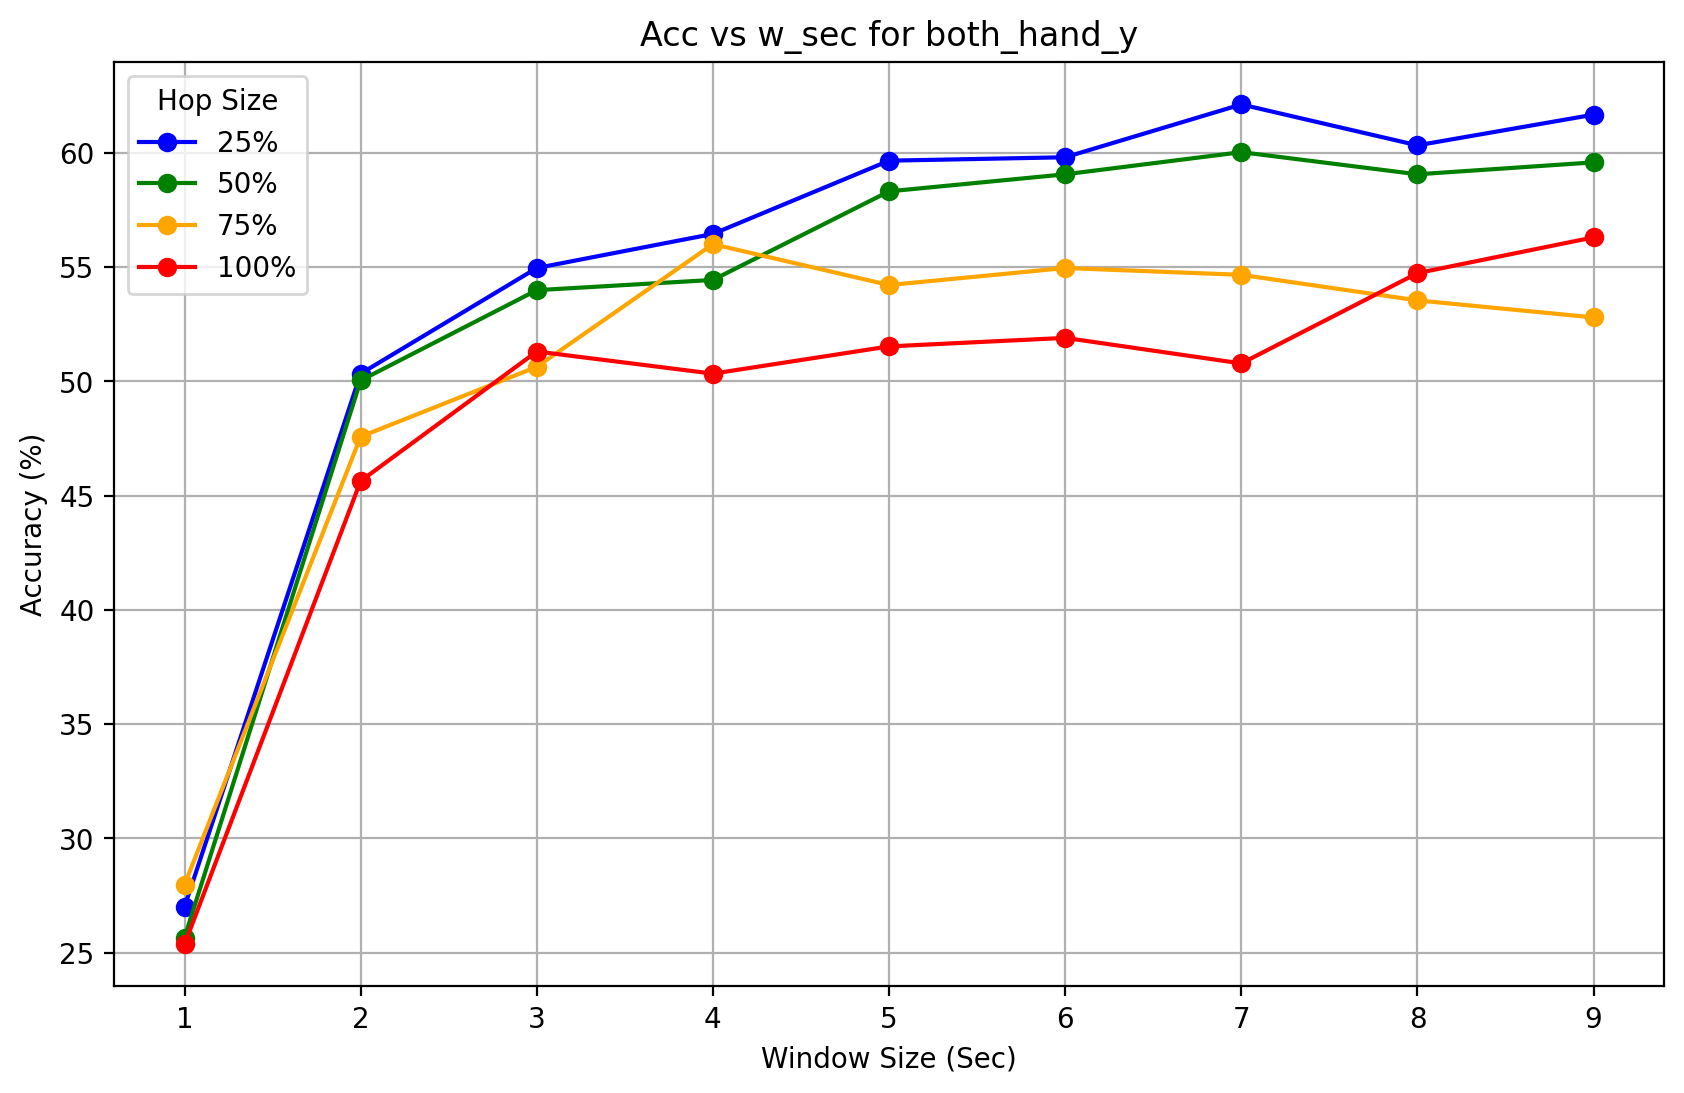

In [7]:
# Define a color mapping for each hop size factor.
# These values correspond to the multipliers: 0.25, 0.5, 0.75, and 1.0.
color_map = {
    0.25: "blue",
    0.5: "green",
    0.75: "orange",
    1.0: "red"
}
pair_keys = ["both_hand_y", "both_foot_y",]

# Choose a segment key, for example:
segment_key = pair_keys[0]

# Convert the corresponding dictionary to a DataFrame.
df_seg = pd.DataFrame(wcase_data[segment_key])

plt.figure(figsize=(10, 6), dpi=200)

# Loop over each unique h_sec value and plot Acc1 vs. w_sec.
for h in sorted(df_seg["h_sec"].unique()):
    # Filter rows for this hop size
    df_h = df_seg[df_seg["h_sec"] == h]
    # Plot: x-axis = w_sec, y-axis = Acc1_bpm_pair
    plt.plot(df_h["w_sec"], df_h["dts_acc"],
             marker="o", 
             label=f"{int(h*100)}%", 
             color=color_map.get(round(h, 2), "black"))
    
plt.xlabel("Window Size (Sec)")
plt.ylabel("Accuracy (%)")
plt.title(f"Acc vs w_sec for {segment_key}")
plt.legend(title="Hop Size")
plt.grid(True)
plt.show()

## Threshold vs. Accuracy

In [8]:
def tau_to_bpm_tolerance(tau, T_ref):
    """
    Convert octave tolerance tau into BPM tolerance around a reference tempo.
    
    Args:
        tau (float): tolerance in octaves (e.g., 0.10)
        T_ref (float): reference tempo in BPM (e.g., 120)
    
    Returns:
        (float, float): lower and upper BPM bounds
    """
    # compute multiplicative factors from tau
    factor = 2 ** tau
    lower = T_ref / factor
    upper = T_ref * factor
    percent = (factor - 1) * 100
    bpm_tolerance = T_ref * (factor - 1)    # BPM tolerance
    
    print(f"For T_ref={T_ref} BPM and tau={tau}, tolerance range = {lower:.2f}–{upper:.2f} BPM")
    print(f"tolerance is ±{percent:.2f}%")
    print(f"which is ±{bpm_tolerance:.2f} BPM")
    
    return lower, upper, percent, bpm_tolerance

# Example:
tau = 0.05
T_ref = 120
tau_to_bpm_tolerance(tau, T_ref)


For T_ref=120 BPM and tau=0.05, tolerance range = 115.91–124.23 BPM
tolerance is ±3.53%
which is ±4.23 BPM


(115.91235947098146, 124.2317908609653, 3.5264923841377582, 4.23179086096531)

In [9]:
pair_keys = ["both_hand_y", "both_foot_y",]

a = 60; b= 140
mode = "zero_uni"
metric = "pos"
w_sec = 5
h_sec = w_sec/2

tau_values = np.round(np.arange(0.025, 0.3, 0.025), 2).tolist()

tau_data = {
    key: {
        "tau": [],
        "dts_acc": [],

    }
    for key in pair_keys
}

for tau in tau_values:

    t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec, tau=tau)
    for ky, itm in t_data.items():
        tau_data[ky]["tau"].append(tau)
        tau_data[ky]["dts_acc"].append(itm)

In [ ]:
def tau_to_percent(tau):
    return (2**tau - 1) * 100

tau_acc = np.round(tau_data["both_hand_y"]["dts_acc"], 2)

# Define tau values and ticks
tau_values = np.round(np.arange(0.025, 0.3, 0.025), 3).tolist()
tick_positions = np.arange(0, 0.31, 0.05)
tick_labels = [f"{t:.2f}\n(±{tau_to_percent(t):.1f}%)" for t in tick_positions]

# Plot
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(tau_values, tau_acc, marker='o', markersize=4)

plt.xticks(tick_positions, tick_labels)
plt.xlabel(r"Tolerance $\tau$ (octaves) with equivalent BPM deviation (%)")
plt.ylabel("Accuracy (%)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [13]:
tau_acc

array([31.17, 47.73, 54.36, 58.31, 61.15, 65.25, 69.28, 71.07, 73.01,
       75.69, 78.08])

In [14]:
tau_values

[0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275]

In [12]:
tick_labels

['0.00\n(±0.0%)',
 '0.05\n(±3.5%)',
 '0.10\n(±7.2%)',
 '0.15\n(±11.0%)',
 '0.20\n(±14.9%)',
 '0.25\n(±18.9%)',
 '0.30\n(±23.1%)']